<a href="https://colab.research.google.com/github/PrattSAVI/ACS/blob/master/NYC_CensusTable.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Retirieveing Data from Census API
This notebook walks through the steps necessary to access Census data through Census API. Currently this notebook only works for census tracts and block groups within NYC. Please open the notebook in Colab to be able to use widgets.

Steps:
* Setup
* Import Geometry
* Retrieve information
* Format tables
* Merge data with shapefiles for mapping. 
* Visualize the information

Please get your API key from Census.gov, by [registering here](https://api.census.gov/data/key_signup.html).


In [1]:
#@title ### Setup
#@markdown Install necessary dependencies
!pip install geopandas
!pip install seaborn 
!pip install plotly

import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

     |████████████████████████████████| 972kB 6.6MB/s 
     |████████████████████████████████| 14.8MB 325kB/s 
     |████████████████████████████████| 6.5MB 28.4MB/s 


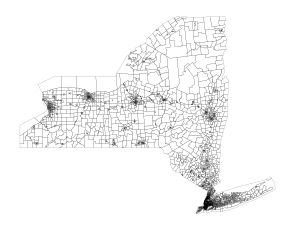

In [5]:
#@title ### Enter Parameters
#@markdown Define Geometry Resolution, Table/Group Name, Product and Year
#@markdown <br>This cell will download data between 5MB to 25MB's  

#@markdown ACS 5 tables.
Table_name = "S1401" #@param ["S1401","B19013", "S1701", "S2201" , "B01001","2301"] {allow-input: true}
#@markdown Only ACS 5 year us supported yet. 
Product = "acs5" #@param[ "acs5", "acs1" ]
Year = "2019" #@param[2019,2018,2017,2016,2015,2014,2013,2012,2011,2010]
api_key = '155e59c93c8216ac7e2a18584db8417bf7279f7f' #@param
Analysis_Geometry = "Census Tract"  #@param ['Census Tract', 'Block Group' ]

if Analysis_Geometry == 'Census Tract':
  Analysis_Geometry = 'tract'
elif Analysis_Geometry == 'Block Group':
  Analysis_Geometry = 'block%20group'

if Analysis_Geometry == 'tract':
  gdf = gpd.read_file( r'https://www2.census.gov/geo/tiger/TIGER' + str(Year) + '/TRACT/tl_' + str(Year) + '_36_tract.zip')
if Analysis_Geometry == 'block%20group':
  gdf = gpd.read_file( r'https://www2.census.gov/geo/tiger/TIGER' + str(Year) + '/BG/tl_' + str(Year) + '_36_bg.zip')

gdf.plot(
    facecolor="none",
    edgecolor="black",
    lw = 0.1,
)
plt.tick_params(left=False , bottom = False , labelleft=False, labelbottom=False)
sns.despine( left = True , bottom = True)
plt.show()

In [36]:
#@title ### Retrieve Data using Census API
#@markdown Census API documenation can be found [here](https://www.census.gov/data/developers/data-sets.html).
bg = pd.DataFrame() #Empty DF to store all info
data_type = None
def get_path( table , geo , api_key ): #Decide which path to use for table or group
  if "S" in table:
    path = r'https://api.census.gov/data/2019/acs/acs5/subject?get=NAME,group(' + table + ')&for=' + geo + ':*&in=state:36&key=' + api_key
    data_type = 'subject'
  if "B" in table:
    data_type = 'table'
    path = r'https://api.census.gov/data/2019/acs/acs5?get=NAME,group(' + table + ')&for=' + geo + ':*&in=state:36&key=' + api_key
  return path , data_type

path,data_type = get_path(Table_name , Analysis_Geometry , api_key )
print ('API URL: ' , path)
df = pd.read_json( path )
df.columns = df.loc[0] #First row to column names
df = df.iloc[1:] #Delete first row

bg = bg.append( df )
bg.sample(3)

API URL:  https://api.census.gov/data/2018/acs/acs5/subject?get=NAME,group(S1401)&for=tract:*&in=state:36&key=155e59c93c8216ac7e2a18584db8417bf7279f7f
subject


,NAME,GEO_ID,S1401_C01_001E,S1401_C01_001M,S1401_C02_001E,S1401_C02_001M,S1401_C03_001E,S1401_C03_001M,S1401_C04_001E,S1401_C04_001M,S1401_C05_001E,S1401_C05_001M,S1401_C06_001E,S1401_C06_001M,S1401_C01_002E,S1401_C01_002M,S1401_C02_002E,S1401_C02_002M,S1401_C03_002E,S1401_C03_002M,S1401_C04_002E,S1401_C04_002M,S1401_C05_002E,S1401_C05_002M,S1401_C06_002E,S1401_C06_002M,S1401_C01_003E,S1401_C01_003M,S1401_C02_003E,S1401_C02_003M,S1401_C03_003E,S1401_C03_003M,S1401_C04_003E,S1401_C04_003M,S1401_C05_003E,S1401_C05_003M,S1401_C06_003E,S1401_C06_003M,S1401_C01_004E,S1401_C01_004M,...,S1401_C06_031MA,S1401_C01_032MA,S1401_C01_032EA,S1401_C02_032EA,S1401_C02_032MA,S1401_C03_032EA,S1401_C03_032MA,S1401_C04_032MA,S1401_C04_032EA,S1401_C05_032EA,S1401_C05_032MA,S1401_C06_032EA,S1401_C06_032MA,S1401_C01_033EA,S1401_C01_033MA,S1401_C02_033EA,S1401_C02_033MA,S1401_C03_033EA,S1401_C03_033MA,S1401_C04_033EA,S1401_C04_033MA,S1401_C05_033EA,S1401_C05_033MA,S1401_C06_033EA,S1401_C06_033MA,S1401_C01_034MA,S1401_C01_034EA,S1401_C02_034EA,S1401_C02_034MA,S1401_C03_034EA,S1401_C03_034MA,S1401_C04_034EA,S1401_C04_034MA,S1401_C05_034EA,S1401_C05_034MA,S1401_C06_034EA,S1401_C06_034MA,state,county,tract
3181,"Census Tract 216.02, Bronx County, New York",1400000US36005021602,1164,282,-888888888.0,-888888888.0,-888888888,-888888888,65.9,11.9,-888888888,-888888888,34.1,11.9,0,17,0.0,2.8,0,17,-666666666.0,-222222222.0,0,17,-666666666.0,-222222222.0,852,242,73.2,10.2,623,201,73.1,14.5,229,147,26.9,14.5,84,76,...,(X),None,None,None,None,None,None,None,None,None,None,None,None,None,None,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),None,None,None,None,None,None,None,None,None,None,None,None,36,005,021602
42,"Census Tract 86.03, New York County, New York",1400000US36061008603,551,218,-888888888.0,-888888888.0,-888888888,-888888888,39.2,17.3,-888888888,-888888888,60.8,17.3,64,54,11.6,8.3,0,12,0.0,37.0,64,54,100.0,37.0,352,164,63.9,15.1,199,120,56.5,23.7,153,112,43.5,23.7,0,12,...,(X),None,None,None,None,None,None,**,-,None,None,-,**,None,None,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),None,None,None,None,None,None,None,None,None,None,None,None,36,061,008603
758,"Census Tract 147.01, Erie County, New York",1400000US36029014701,1444,146,-888888888.0,-888888888.0,-888888888,-888888888,85.0,6.0,-888888888,-888888888,15.0,6.0,116,55,8.0,3.9,69,44,59.5,29.3,47,42,40.5,29.3,1033,123,71.5,6.2,946,128,91.6,6.7,87,71,8.4,6.7,76,47,...,(X),None,None,None,None,None,None,None,None,None,None,None,None,None,None,(X),(X),(X),(X),(X),(X),(X),(X),(X),(X),None,None,None,None,None,None,None,None,None,None,None,None,36,029,014701


In [ ]:
#@title ### Clean Empty Fields
#@markdown American Community Survey Tables incicate missing data in manny different formats for specific purposes. 
#@markdown This cell converts all these values to Null. For income tables, values above 250,000+ are converted to 250001.
#Remove all values keeping the columns to be converted to numeric

data_cols = bg.columns[ bg.columns.str.contains( Table_name ) ]
for _ in data_cols.tolist():
  bg.loc[ bg[_] ==  '(X)' , _ ] = None
  bg.loc[ bg[_] ==  '*' , _ ] = None
  bg.loc[ bg[_] ==  '**' , _ ] = None
  bg.loc[ bg[_] ==  '***' , _ ] = None
  bg.loc[ bg[_] ==  '-' , _ ] = None
  bg.loc[ bg[_] ==  'N' , _ ] = None
  bg.loc[ bg[_] ==  '250,000+' , _ ] = 250001
  bg.loc[ bg[_] ==  -666666666 , _ ] = None
  bg.loc[ bg[_] ==  -888888888 , _ ] = None
  bg.loc[ bg[_] ==  -222222222 , _ ] = None
  bg.loc[ bg[_] ==  '2,500-' , _ ] = 2499
  bg[_] = bg[_].astype( float )

bg.sample(3)

In [34]:
#@title ### Change Column Names
delete_MOE = True #@param {type:"boolean"}

#@markdown This is the list of all columns available to be replaces  <br>
#@markdown https://api.census.gov/data/2019/acs/acs5/variables.json <br>
#@markdown https://api.census.gov/data/2019/acs/acs5/subject/variables.json
bg_clean = bg.copy() #New df for the cleaned data

#Check if the column names mantch with the varialablkes
#Cehck group if this does not work .
print(data_type)
if data_type == 'table':
  cols = pd.read_json( r'https://api.census.gov/data/2019/acs/acs5/variables.json' )
if data_type == 'subject':
  cols = pd.read_json( r'https://api.census.gov/data/2019/acs/acs5/subject/variables.json' )

display( cols[cols.index.str.contains(Table_name) ].sample(3) )

label = []
if len( cols[ cols.index.isin( bg_clean.columns.tolist() ) ] ) != 0:
  print('A')
  for c in bg_clean.columns.tolist():
      temp = cols[ cols.index == c ]
      if len(temp) != 0:
        label.append( temp['variables'][0]['label']  )
      else:
        label.append( c )

if len( cols[ cols.index.isin( bg_clean.columns.tolist() ) ] ) == 0:
  print( 'B' )
  cols = pd.read_json( 'https://api.census.gov/data/2017/acs/acs5/subject/groups/' + Table_name + '.json' )
  for c in bg_clean.columns.tolist():
      temp = cols[ cols.index == c ]
      if len(temp) != 0:
        label.append( temp['variables'][0]['label']  )
      else:
        label.append( c )

bg_clean.columns = label 
bg_clean = bg_clean.dropna( how = 'all' , axis = 1) #Remove columns if there is no value  

bg_clean = bg_clean.loc[:,~bg_clean.columns.duplicated()] #Remove duplicate NAME Columns
bg_clean = bg_clean[ bg_clean.columns[ ~bg_clean.columns.str.contains('EA') ] ] #Remove Annotations Columns
bg_clean = bg_clean[ bg_clean.columns[ ~bg_clean.columns.str.contains('MA') ] ] #Remove Annotations Columns
bg_clean = bg_clean[ bg_clean.columns[ bg_clean.columns.str[-1:] != 'M' ] ]

if delete_MOE == True:
  bg_clean = bg_clean[ bg_clean.columns[ ~bg_clean.columns.str.contains('Margin of Error') ] ] #Remove Annotations Columns
bg_clean.sample( 3 )

None


ValueError: ignored

In [33]:
cols[ cols.index.str.contains( Table_name) ]
#display( cols[cols.index.str.contains(Table_name) ].sample(3) )


,variables


In [8]:
#@title ### Join Census table with geometry
#@markdown Isolate the counties below. 
#Join Census table with geometry

counties = "005,047,061,081,085" #@param {type:"string"}
counties = counties.split(',')

gdf['GEOID_2'] = '1400000US' + gdf['GEOID']
gdf = gdf.join( bg_clean.set_index('Geography') , on = 'GEOID_2' , rsuffix = '_D' )

gdf = gdf[ gdf['county'].isin( counties )]

gdf.head(3)

,STATEFP,COUNTYFP,TRACTCE,GEOID,NAME,NAMELSAD,MTFCC,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry,GEOID_2,NAME_D,S1401_C01_001E,S1401_C01_001M,S1401_C02_001E,S1401_C02_001M,S1401_C03_001E,S1401_C03_001M,S1401_C04_001E,S1401_C04_001M,S1401_C05_001E,S1401_C05_001M,S1401_C06_001E,S1401_C06_001M,S1401_C01_002E,S1401_C01_002M,S1401_C02_002E,S1401_C02_002M,S1401_C03_002E,S1401_C03_002M,S1401_C04_002E,S1401_C04_002M,S1401_C05_002E,S1401_C05_002M,S1401_C06_002E,S1401_C06_002M,S1401_C01_003E,...,S1401_C06_031M,S1401_C01_032E,S1401_C01_032M,S1401_C02_032E,S1401_C02_032M,S1401_C03_032E,S1401_C03_032M,S1401_C04_032E,S1401_C04_032M,S1401_C05_032E,S1401_C05_032M,S1401_C06_032E,S1401_C06_032M,S1401_C01_033E,S1401_C01_033M,S1401_C02_033E,S1401_C02_033M,S1401_C03_033E,S1401_C03_033M,S1401_C04_033E,S1401_C04_033M,S1401_C05_033E,S1401_C05_033M,S1401_C06_033E,S1401_C06_033M,S1401_C01_034E,S1401_C01_034M,S1401_C02_034E,S1401_C02_034M,S1401_C03_034E,S1401_C03_034M,S1401_C04_034E,S1401_C04_034M,S1401_C05_034E,S1401_C05_034M,S1401_C06_034E,S1401_C06_034M,state,county,tract
0,36,081,044800,36081044800,448,Census Tract 448,G5020,S,208002,0,+40.7110219,-073.8026344,"POLYGON ((-73.80646 40.71206, -73.80556 40.712...",1400000US36081044800,"Census Tract 448, Queens County, New York",867.0,156.0,-888888888.0,-888888888.0,-888888888.0,-888888888.0,88.9,7.7,-888888888.0,-888888888.0,11.1,7.7,69.0,47.0,8.0,5.2,45.0,38.0,65.2,31.5,24.0,27.0,34.8,31.5,566.0,...,-888888888.0,56.0,48.0,35.0,23.1,56.0,48.0,100.0,39.6,0.0,12.0,0.0,39.6,155.0,50.0,-888888888.0,-888888888.0,-888888888.0,-888888888.0,-888888888.0,-888888888.0,-888888888.0,-888888888.0,-888888888.0,-888888888.0,105.0,48.0,67.7,19.9,99.0,47.0,94.3,8.8,6.0,10.0,5.7,8.8,36,081,044800
1,36,081,045800,36081045800,458,Census Tract 458,G5020,S,245281,0,+40.7152626,-073.7909261,"POLYGON ((-73.79364 40.71382, -73.79362 40.713...",1400000US36081045800,"Census Tract 458, Queens County, New York",527.0,121.0,-888888888.0,-888888888.0,-888888888.0,-888888888.0,74.0,10.6,-888888888.0,-888888888.0,26.0,10.6,34.0,21.0,6.5,4.7,5.0,13.0,14.7,38.7,29.0,23.0,85.3,38.7,379.0,...,-888888888.0,13.0,16.0,72.2,42.6,9.0,15.0,69.2,56.2,4.0,7.0,30.8,56.2,25.0,19.0,-888888888.0,-888888888.0,-888888888.0,-888888888.0,-888888888.0,-888888888.0,-888888888.0,-888888888.0,-888888888.0,-888888888.0,15.0,13.0,60.0,43.5,6.0,8.0,40.0,47.6,9.0,9.0,60.0,47.6,36,081,045800
2,36,081,046200,36081046200,462,Census Tract 462,G5020,S,249611,0,+40.7098547,-073.7879749,"POLYGON ((-73.79203 40.71107, -73.79101 40.711...",1400000US36081046200,"Census Tract 462, Queens County, New York",1748.0,473.0,-888888888.0,-888888888.0,-888888888.0,-888888888.0,91.9,6.5,-888888888.0,-888888888.0,8.1,6.5,51.0,55.0,2.9,3.3,21.0,35.0,41.2,58.8,30.0,50.0,58.8,58.8,1141.0,...,-888888888.0,165.0,98.0,47.1,25.4,110.0,85.0,66.7,32.0,55.0,55.0,33.3,32.0,387.0,207.0,-888888888.0,-888888888.0,-888888888.0,-888888888.0,-888888888.0,-888888888.0,-888888888.0,-888888888.0,-888888888.0,-888888888.0,118.0,146.0,30.5,30.8,118.0,146.0,100.0,23.7,0.0,17.0,0.0,23.7,36,081,046200


In [9]:
#Mapping - Take a long time.

import ipywidgets as widgets
from IPython.display import display
from IPython.display import clear_output

w = widgets.Dropdown(
    options= gdf.columns.tolist(),
    description='Choose Column to Visualize:',
    disabled=False,
)

def on_change(change):#Dropdown on_change event
    if change['type'] == 'change' and change['name'] == 'value':
        mapper( change['new'] , gdf )

w.observe( on_change )

print( "Choose a Column to continue!")
display(w)

import plotly.express as px

def mapper(viz_col , gdf): #Mapping is here
  clear_output(wait=True)
  display(w)
  gdf_map = gdf[ gdf[viz_col] > -50000 ] 
  fig = px.choropleth_mapbox(gdf_map , geojson=gdf_map.geometry , locations=gdf_map.index,
                            color= viz_col,opacity = 0.6,
                            hover_name= viz_col ,
                            center={"lat": 40.71, "lon": -74.00},zoom=9,
                            mapbox_style="carto-positron",
                            color_continuous_scale="BuPu", # Here are more colors: https://plotly.com/python/builtin-colorscales/
                          )

  fig.update_traces( marker = dict( line=dict(width=0) ) )
  fig.update_layout(width=800,height=600)
  fig.show()


Dropdown(description='Choose Column to Visualize:', index=17, options=('STATEFP', 'COUNTYFP', 'TRACTCE', 'GEOI…